https://docs.google.com/document/d/1DOZR1lDYQd6esKRnqVFEMGzQ6nubJq4tk10_o8ns4gw/edit?usp=sharing

The data we are using is called AG news. The dataset contains 120000 training datasets containing a short header for a news article and a corresponding label for the header. There are four possible classes for the labels, ***World***, ***Sports***, ***Business*** and ***Sci/Tech***. 

Since the dataset comes with the ground truth label, we can try to come up with a classification model that will correctly label an article header. We can also try different clustering algorithms to see if we can find any interesting structures within the articles. 

In [1]:
# import dataset to be used. Instead of downloading it, i decided to just get it from torchtext
from torchtext.datasets import AG_NEWS
# counter to count word counts
from collections import Counter
# iterators that we can use to get the data
train_dataset_iterator, test_dataset_iterator = AG_NEWS()
# pandas for dataframe
import pandas as pd
# spacy for nlp preprocessing (lemmatization, stemming)
import spacy

import numpy as np

#sentence_list holds a tuple of (label, text)
sentence_list = []

def tokenize(line):
    #given an input str split it into tokens
    return line.split()

# list of tokens from the data
train_tokens = []

# iterate through each data
for label, line in train_dataset_iterator:
    # replace '\\'
    line = line.replace("\\", " ")
    # replace ;, or :
    line = line.replace(":", " ")
    line = line.replace(";", " ")
    # replace $ signs
    line = line.replace("$", " ")
    # sentence_list later gets used to create a corpus
    sentence_list.append((label,line))
    # append with tokens
    train_tokens += tokenize(line)

# get the total number of tokens in the news data, there are 4541694 total number of tokens
print(len(train_tokens))

word_counts = Counter(train_tokens)
# 10 most common words
print(word_counts.most_common(10))



ModuleNotFoundError: No module named 'torchtext'

In [2]:
print(len(word_counts))

165239


## Data / Preprocessing 

Since the data we are dealing with are news article headers, the data we are dealing with are words. After simply tokenizing each words in our training dataset, we end up with 4,626,262 words total with 165,239 unique words. Given that the articles we are dealing with are written in English it is unsurprising that the most commonly occuring words are indefinite articles such as "The", "to" and "a". These words can be helpful in language modeling tasks where we need to generate coherent sentences, but these phrases serve almost no purpose for us as they occur in pretty much every article in our dataset. Words like these are called ***stop words*** and it is quite benefitial to get rid of these words as they really don't help with our tasks. 


In [3]:
# turn the list of sentences into a pandas DF. It's probabily a little easier to work with the data this way
sentence_df = pd.DataFrame(sentence_list)
sentence_df = sentence_df.rename(columns={0: 'label', 1: 'sentence'})

In [4]:
sentence_df.head()

,label,sentence
0,3,Wall St. Bears Claw Back Into the Black (Reute...
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...
4,3,"Oil prices soar to all-time record, posing new..."


In [5]:
# the dataset is quite balanced
sentence_df.groupby('label').count()

,sentence
label,
1,30000
2,30000
3,30000
4,30000


In [6]:
keys = np.array(list(word_counts.keys()))
counts = np.array(list(word_counts.values()))

In [7]:
# total number of unique words
print(len(keys))
print(len(counts))

165239
165239


In [8]:
#percent of words that occur more than 5 times in the corpus. 
len(np.where(counts > 5)[0]) / len(counts)

0.24523871483124443

In [9]:
#percent of words that occur once in the corpus. Almost half the tokens occur only once. 
len(np.where(counts == 1)[0]) / len(counts)

0.4647752649192987

In [10]:
# get 10 least common words
temp_list = word_counts.most_common()
temp_list.reverse()
print(temp_list[:10])

[('43-27-3.', 1), ('10-1-2,', 1), ('Shivering', 1), ('wind-affected', 1), ('three-book', 1), ('Obama,', 1), ('fault-filled', 1), ("'offensive'", 1), ('interrogating', 1), ('Quizzing', 1)]


In [11]:
# get the words that appear only once in the corpus
word_appearing_once = []
for word, counts in word_counts.items():  # for name, age in dictionary.iteritems():  (for Python 2.x)
    if counts == 1:
        word_appearing_once.append(word)

In [12]:
word_appearing_once[:10]

['Tearaway',
 '(DELL.O)',
 '849.98',
 'PH.D.',
 'Sociology,',
 'Bazil',
 '70,000.',
 'brochures',
 '"buying',
 'mind,"']


## More Preprocessing ##

As mentioned earlier words that are guaranteed to occur in almost all documents are quite useless for our tasks. However we need to also look at words that occur very infrequently in our data. These words may actually be benefitial in identifying a specific news article, however given we are interested in creating a model that can classify a news article, these words maybe too specific to a particular article and may not help us come up with a model that can generalize to unseen data. 

Some of the words are shown above, and they include words that are numbers or names that appear very infrequently and either need to be deleted from the dataset or merged into other words as they will serve no purpose otherwise.

Another type of data preprocessing that we need to perform is stemming and lemmatizing. A lot of word tokens in our documents convey the same meaning but have varying forms due to gramatical reasons. The word learn as shown below would be a good example of this. Both the phrases 'learn' and 'learns' has the exact same meaning however they are used in different scenarios. Treating them as a separate entities leads us to have more dimensions to our data than what our data actually conveys and by lemmatizing them into their basic form of 'learn', we can maintain the meaning behind the word while reducing the dimension of our dataset. 

https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html
https://stackoverflow.com/questions/1787110/what-is-the-difference-between-lemmatization-vs-stemming
https://blog.bitext.com/what-is-the-difference-between-stemming-and-lemmatization/

In [13]:
# why stemming is needed. Word learn- gets used multiple times in the corpus. By stemming the words into the base form 
# learn, we are in a way reducing the features space. 
print(word_counts['learn'])
print(word_counts['learns'])
print(word_counts['learning'])
print(word_counts['learned'])

121
15
64
114


In [14]:
# help with enabling parallel processing.
import multiprocessing
num_cpu_use = multiprocessing.cpu_count() - 1
print(num_cpu_use)

31


In [15]:
%%time
# load a pre-compiled list of stopwords
from spacy.lang.en.stop_words import STOP_WORDS
nlp = spacy.load("en_core_web_sm")

# the pipeline takes in a list of list of strings
texts = sentence_df['sentence'].tolist()

corpus = []


#for doc in nlp.pipe(texts, disable=["tok2vec", "ner"], n_process=num_cpu_use, batch_size=num_cpu_use * 32):
for doc in nlp.pipe(texts, n_process=num_cpu_use, batch_size=num_cpu_use * 32):
    
    sentence = ''
    
    for token in doc:
        word = token.text.lower()
        # make sure we get rid of stopwords, punctuation, or numbers
        if word not in STOP_WORDS and not token.is_punct and not token.like_num:
            #sentence.append(token.lemma_)
            #if token.lemma_ == 'learns':
            #    print(token, token.lemma_)
            #if token.lemma_ == 'learn':
            #    print(token, token.lemma_)
            sentence = sentence + token.lemma_ + ' '
    corpus.append(sentence)

CPU times: user 1min 5s, sys: 6.05 s, total: 1min 11s
Wall time: 1min 33s


In [16]:
len(corpus)

120000

In [17]:
# turn the list of sentences into a column in our pandas DF.
sentence_df['cleaned'] = pd.DataFrame(corpus)

In [18]:
sentence_df.head()

,label,sentence,cleaned
0,3,Wall St. Bears Claw Back Into the Black (Reute...,Wall St. Bears Claw Black Reuters Reuters Shor...
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Carlyle look Commercial Aerospace Reuters Reut...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters...,Oil Economy Cloud Stocks Outlook Reuters Reute...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Iraq Halts Oil Exports Main Southern Pipeline ...
4,3,"Oil prices soar to all-time record, posing new...",oil price soar time record pose new menace eco...


In [19]:
corpus[0]

'Wall St. Bears Claw Black Reuters Reuters Short seller Wall Street dwindle band ultra cynic see green '

In [20]:
# list of tokens from the data
cleaned_tokens = []

# iterate through each data
for line in corpus:
    cleaned_tokens += tokenize(line)

In [21]:
clean_word_counts = Counter(cleaned_tokens)
# 10 most common words
print(clean_word_counts.most_common(10))
# get the total number of tokens in the news data, there are 4541694 total number of tokens
print(len(clean_word_counts))


[('s', 31378), ('say', 26645), ('Reuters', 17258), ('AP', 16248), ('year', 14002), ('new', 11942), ('lt', 9739), ('company', 9602), ('quot', 9593), ('win', 8015)]
78362


In [22]:
cleaned_text = sentence_df['cleaned'].tolist()

In [23]:
# why stemming is needed. Word learn- gets used multiple times in the corpus. By stemming the words into the base form 
# learn, we are in a way reducing the features space. 
print(clean_word_counts['learn'])
print(clean_word_counts['learns'])
print(clean_word_counts['learning'])
print(clean_word_counts['learned'])

407
0
20
0


In [24]:
len(clean_word_counts)

78362

## After Lemmatization

After we go through the process of lemmatizing our words, we can clearly see that most variants of the word 'learn', such as 'learns' or 'learned' has been reduced to the basic form 'learn'. This reduces the dimension of our data and should help us fit a better model. 

Before we applied lemmatization, we had 165,239 words with 120,000 training data, however after lemmatization we end up with 78,362 words. This greatly reduces the dimension of our data which should increase computational efficiency of our modeling effort.



In [25]:
clean_keys = np.array(list(clean_word_counts.keys()))
clean_counts = np.array(list(clean_word_counts.values()))

#percent of words that occur more than 5 times in the corpus. 
len(np.where(clean_counts > 5)[0]) / len(clean_counts)


0.31655649421913684

In [26]:
#percent of words that occur once in the corpus. Almost half the tokens occur only once. 
len(np.where(clean_counts == 1)[0]) / len(clean_counts)

0.39410683749776676

In [27]:
word_appearing_once = []
for word, counts in clean_word_counts.items():  # for name, age in dictionary.iteritems():  (for Python 2.x)
    if counts == 1:
        word_appearing_once.append(word)


In [28]:
word_appearing_once[:10]

['Tearaway',
 'Sociology',
 'Bazil',
 'oversupplie',
 'purnomo',
 '55.8bn',
 'mauritian',
 'Baylis',
 'Freeplay',
 'clockwork']

In [29]:
type(clean_word_counts)

collections.Counter

In [30]:
print(len(sentence_df['cleaned']))

120000


In [31]:
from pyspark.sql import SparkSession

# using pyspark to make things go a little faster

#Create PySpark SparkSession
spark = SparkSession.builder.appName("Temp").getOrCreate()

#Create PySpark DataFrame from Pandas
spark_df=spark.createDataFrame(sentence_df) 
spark_df.printSchema()
spark_df.show()


21/11/15 17:55:45 WARN Utils: Your hostname, youngwook-desktop resolves to a loopback address: 127.0.1.1; using 192.168.1.192 instead (on interface enp11s0)
21/11/15 17:55:45 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
21/11/15 17:55:45 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


root
 |-- label: long (nullable = true)
 |-- sentence: string (nullable = true)
 |-- cleaned: string (nullable = true)



21/11/15 17:55:49 WARN TaskSetManager: Stage 0 contains a task of very large size (1306 KiB). The maximum recommended task size is 1000 KiB.


+-----+--------------------+--------------------+
|label|            sentence|             cleaned|
+-----+--------------------+--------------------+
|    3|Wall St. Bears Cl...|Wall St. Bears Cl...|
|    3|Carlyle Looks Tow...|Carlyle look Comm...|
|    3|Oil and Economy C...|Oil Economy Cloud...|
|    3|Iraq Halts Oil Ex...|Iraq Halts Oil Ex...|
|    3|Oil prices soar t...|oil price soar ti...|
|    3|Stocks End Up, Bu...|stock end Near Ye...|
|    3|Money Funds Fell ...|money Funds fall ...|
|    3|Fed minutes show ...|Fed minute dissen...|
|    3|Safety Net (Forbe...|Safety Net Forbes...|
|    3|Wall St. Bears Cl...|Wall St. Bears Cl...|
|    3|Oil and Economy C...|Oil Economy Cloud...|
|    3|No Need for OPEC ...|need OPEC pump Ir...|
|    3|Non-OPEC Nations ...|Non OPEC Nations ...|
|    3|Google IPO Auctio...|Google ipo Auctio...|
|    3|Dollar Falls Broa...|dollar Falls Broa...|
|    3|Rescuing an Old S...|rescue Old Saver ...|
|    3|Kids Rule for Bac...|Kids rule school ...|


In [32]:
# repartition to make the process a bit faster hopefully
spark_df = spark_df.repartition(num_cpu_use * 10 )
print(spark_df.rdd.getNumPartitions())

310


In [33]:
spark_df.show(10)

21/11/15 17:55:49 WARN TaskSetManager: Stage 1 contains a task of very large size (1306 KiB). The maximum recommended task size is 1000 KiB.


+-----+--------------------+--------------------+
|label|            sentence|             cleaned|
+-----+--------------------+--------------------+
|    3|Shippers  Venezue...|Shippers   Venezu...|
|    3|Expansion slows i...|expansion slow Ja...|
|    4|Cops Test Handhel...|cop Test Handheld...|
|    2|American Duo Wins...|American Duo Wins...|
|    3|Strategies for a ...|strategy Sideways...|
|    4|AccuRev touts sof...|AccuRev tout soft...|
|    4|Taking the Pulse ...|take Pulse Planet...|
|    3|Venezuela's Chave...|Venezuela Chavez ...|
|    3|Consumer Prices D...|consumer Prices D...|
|    1|Official backs Sc...|official back Scr...|
+-----+--------------------+--------------------+
only showing top 10 rows




[Stage 1:>                                                        (0 + 32) / 32]



In [34]:
from pyspark.sql.functions import col
import pyspark.sql.functions as fn
from pyspark.sql.window import Window


In [35]:
spark_df.select(col('cleaned')).show(20)

21/11/15 17:55:50 WARN TaskSetManager: Stage 3 contains a task of very large size (1306 KiB). The maximum recommended task size is 1000 KiB.


+--------------------+
|             cleaned|
+--------------------+
|MCI overhaul netw...|
|home pc key Windo...|
|U.N. Food Agency ...|
|worker allege sex...|
|BHP profit rise c...|
|Google offering W...|
|Chandra Celebrate...|
|Fall Season look ...|
|Golds U.S. Misfir...|
|Edwards ban Games...|
|Carly Patterson P...|
|Probe expand gree...|
|different world N...|
|burundian rebel  ...|
|mexican car worke...|
|COTE D IVOIRE   s...|
|Mars Exploration ...|
|Koch   support Bu...|
|Tokyo Stocks Trea...|
|check marital sta...|
+--------------------+
only showing top 20 rows



In [36]:
# Split the string into tokens.

from pyspark.sql.functions import split, explode

splitworddf = spark_df.select(col('label'), split(col('cleaned'), ' ').alias('split'))


In [37]:
splitworddf.show(10)

21/11/15 17:55:50 WARN TaskSetManager: Stage 5 contains a task of very large size (1306 KiB). The maximum recommended task size is 1000 KiB.


+-----+--------------------+
|label|               split|
+-----+--------------------+
|    4|[Windows, Unix, ,...|
|    2|[Budapest, Free, ...|
|    1|[Chavez, Survives...|
|    1|[communist, conde...|
|    3|[stock, open, low...|
|    3|[Google, Minus, ,...|
|    4|[Insider, informa...|
|    4|[video, game, REV...|
|    3|[Nestle, Reports,...|
|    1|[Mass., Republica...|
+-----+--------------------+
only showing top 10 rows



In [38]:
splitworddf.printSchema()

root
 |-- label: long (nullable = true)
 |-- split: array (nullable = true)
 |    |-- element: string (containsNull = true)



In [39]:
type(splitworddf.split)

pyspark.sql.column.Column

In [40]:

splitworddfsingle = splitworddf.select(explode(splitworddf.split).alias('word'))
splitworddfsingle.show(10)
shakeWordsDF = splitworddfsingle.where(splitworddfsingle.word != '')
#shakeWordsDF.show()
shakeWordsDFCount = shakeWordsDF.count()


21/11/15 17:55:51 WARN TaskSetManager: Stage 7 contains a task of very large size (1306 KiB). The maximum recommended task size is 1000 KiB.


+-------------+
|         word|
+-------------+
|          MCI|
|     overhaul|
|      network|
|international|
|         call|
|      Company|
|         plan|
|          use|
|           ip|
|         base|
+-------------+
only showing top 10 rows



21/11/15 17:55:51 WARN TaskSetManager: Stage 9 contains a task of very large size (1306 KiB). The maximum recommended task size is 1000 KiB.


In [41]:
words_counts_df = shakeWordsDF.groupby(col('word')).count().withColumnRenamed("count", 'word_counts')

In [42]:
# Get some statistics on word occurence such as mean, variance and max

from pyspark.sql.functions import mean, variance, max

# get some stat on the word counts
words_counts_df.select(mean(col('word_counts'))).show()

# get some stat on the word counts
words_counts_df.select(variance(col('word_counts'))).show()

# get some stat on the word counts
words_counts_df.select(max(col('word_counts'))).show()


21/11/15 17:55:52 WARN TaskSetManager: Stage 12 contains a task of very large size (1306 KiB). The maximum recommended task size is 1000 KiB.
21/11/15 17:55:57 WARN TaskSetManager: Stage 16 contains a task of very large size (1306 KiB). The maximum recommended task size is 1000 KiB.


+-----------------+
| avg(word_counts)|
+-----------------+
|37.06417651412674|
+-----------------+



21/11/15 17:56:01 WARN TaskSetManager: Stage 20 contains a task of very large size (1306 KiB). The maximum recommended task size is 1000 KiB.


+---------------------+
|var_samp(word_counts)|
+---------------------+
|    83018.49262077194|
+---------------------+



+----------------+
|max(word_counts)|
+----------------+
|           31378|
+----------------+



In [43]:
# calculate quantiles

# get some stat on the word counts
words_counts_df.approxQuantile('word_counts', [.25, .5, .75, .90], 0.01)

# the outputs are [1.0, 2.0, 5.0, 31378.0], meaning that the median word count for our words is 2.0. So about 
# half of the words in our dataset appear only twice and 75 percent of our dataset appear 5 times or fewer. We
# might want to try out only using words whose count is greater than some minimum threashold 
# and less than some maximum threshold

21/11/15 17:56:04 WARN TaskSetManager: Stage 24 contains a task of very large size (1306 KiB). The maximum recommended task size is 1000 KiB.


[1.0, 2.0, 8.0, 35.0]

In [44]:
min_quantile = 0.75
max_quantile = 0.9
cutoff_range = words_counts_df.approxQuantile('word_counts', [min_quantile, max_quantile], 0.1)

21/11/15 17:56:08 WARN TaskSetManager: Stage 28 contains a task of very large size (1306 KiB). The maximum recommended task size is 1000 KiB.


21/11/15 17:56:11 WARN TaskSetManager: Stage 32 contains a task of very large size (1306 KiB). The maximum recommended task size is 1000 KiB.


<AxesSubplot:title={'center':'Word Frequencies'}>

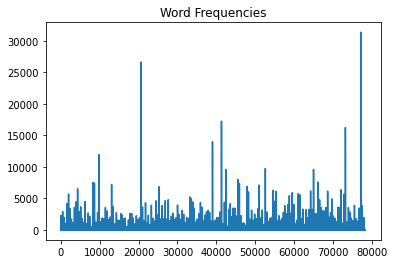

In [45]:
# plot occurences before eliminating words 
words_counts_df.toPandas()['word_counts'].plot.line(title="Word Frequencies")

In [46]:
# filter out words with fewer than X number of occurances or more than X number of occurances. 

minimum = cutoff_range[0]
maximum = cutoff_range[1]

# get the pyspark df of words that occur more than X number of times
get_rid_of_df = words_counts_df.filter((col('word_counts') < minimum) | (col('word_counts') > maximum))
# convert to pandas to make it easier to convert it to list
get_rid_of_df = get_rid_of_df.toPandas()
# turn pandas df into a list. 
list_of_words_to_get_rid = list(get_rid_of_df['word'])

21/11/15 17:56:15 WARN TaskSetManager: Stage 35 contains a task of very large size (1306 KiB). The maximum recommended task size is 1000 KiB.


In [47]:
from pyspark.sql.functions import desc

#words_counts_df = words_counts_df.sort(desc('word_counts'))
words_counts_df_pd = words_counts_df.toPandas()

In [48]:
words_counts_df_pd['word_counts']

0          30
1         534
2        2281
3          91
4         196
         ... 
78357       1
78358       1
78359       1
78360       1
78361       1
Name: word_counts, Length: 78362, dtype: int64

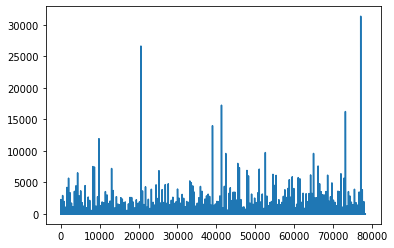

In [49]:
ax = words_counts_df_pd['word_counts'].plot.line()

In [50]:
list_of_words_to_get_rid[:10]

['bolden',
 'accumulation',
 'Drink',
 'Techsters',
 'Soliman',
 'Cuqua',
 'countermeasure',
 '61pc',
 'tortured',
 'Montreal-']

In [51]:
'''
Not really needed
'''

from pyspark.sql.functions import udf
from pyspark.sql.types import *


def remove_stop_words(list_of_tokens, list_of_stopwords):
    '''
    A very simple fuction that takes in a list of word tokens and then gets rid of words that are in stopwords list
    '''
    return [token for token in list_of_tokens if token not in list_of_stopwords]

def udf_remove_stop_words(list_of_stopwords):
    '''
    creates a udf that takes in a list of stop words and passes them onto remove_stop_words
    '''
    return udf(lambda x: remove_stop_words(x, list_of_stopwords))


In [52]:
import pyspark.sql.functions as F
import pyspark.sql.types as T

#convert_to_lower = udf(remove_stop_words, ArrayType(StringType()))

#shakeWordsNoStopDF = splitworddf.withColumn('removed', convert_to_lower(col('split'), list_of_words_to_get_rid))
#shakeWordsNoStopDF = splitworddf.withColumn('removed', udf_remove_stop_words(list_of_words_to_get_rid)(col('split')))


In [53]:
splitworddf.show(10)

21/11/15 17:56:20 WARN TaskSetManager: Stage 41 contains a task of very large size (1306 KiB). The maximum recommended task size is 1000 KiB.


+-----+--------------------+
|label|               split|
+-----+--------------------+
|    4|[Windows, Unix, ,...|
|    2|[Budapest, Free, ...|
|    1|[Chavez, Survives...|
|    1|[communist, conde...|
|    3|[stock, open, low...|
|    3|[Google, Minus, ,...|
|    4|[Insider, informa...|
|    4|[video, game, REV...|
|    3|[Nestle, Reports,...|
|    1|[Mass., Republica...|
+-----+--------------------+
only showing top 10 rows



In [54]:
# remove words in list_of_words_to_get_rid, the list of words would change based on the hyperparameters used

shakeWordsNoStopDF = splitworddf.withColumn('removed', F.array_except(F.col('split'), F.array(*[F.lit(w) for w in list_of_words_to_get_rid])))#.drop("cleaned")

In [55]:
shakeWordsNoStopDF.show(10)

21/11/15 17:56:46 WARN TaskSetManager: Stage 43 contains a task of very large size (1306 KiB). The maximum recommended task size is 1000 KiB.


+-----+--------------------+--------------------+
|label|               split|             removed|
+-----+--------------------+--------------------+
|    4|[Windows, Unix, ,...|[Windows, Unix, ,...|
|    2|[Budapest, Free, ...|[Budapest, Free, ...|
|    1|[Chavez, Survives...|[Chavez, Survives...|
|    1|[communist, conde...|[communist, conde...|
|    3|[stock, open, low...|[stock, open, low...|
|    3|[Google, Minus, ,...|[Google, , drop, ...|
|    4|[Insider, informa...|[Insider, informa...|
|    4|[video, game, REV...|[video, game, REV...|
|    3|[Nestle, Reports,...|[Nestle, Reports,...|
|    1|[Mass., Republica...|[Mass., Republica...|
+-----+--------------------+--------------------+
only showing top 10 rows



21/11/15 17:56:46 WARN DAGScheduler: Broadcasting large task binary with size 1029.5 KiB


In [56]:
shakeWordsNoStopDF.printSchema()

root
 |-- label: long (nullable = true)
 |-- split: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- removed: array (nullable = true)
 |    |-- element: string (containsNull = true)



In [57]:
# recombine tokens into strings

from pyspark.sql.functions import concat_ws
from pyspark.sql.functions import array_join

shakeWordsNoStopDF = shakeWordsNoStopDF.withColumn("removed_combined", array_join("removed", " "))

In [58]:
# convert pyspark dataframe into pandas dataframe. not sure if entirely necessary
pd_df = shakeWordsNoStopDF.select([col('label'), col('removed_combined')]).toPandas()

21/11/15 17:56:46 WARN TaskSetManager: Stage 45 contains a task of very large size (1306 KiB). The maximum recommended task size is 1000 KiB.
21/11/15 17:56:47 WARN DAGScheduler: Broadcasting large task binary with size 1027.8 KiB


In [59]:
shakeWordsNoStopDF.show()

21/11/15 17:58:18 WARN TaskSetManager: Stage 47 contains a task of very large size (1306 KiB). The maximum recommended task size is 1000 KiB.


+-----+--------------------+--------------------+--------------------+
|label|               split|             removed|    removed_combined|
+-----+--------------------+--------------------+--------------------+
|    4|[Windows, Unix, ,...|[Windows, Unix, ,...|Windows Unix  hea...|
|    2|[Budapest, Free, ...|[Budapest, Free, ...|Budapest Free Pra...|
|    1|[Chavez, Survives...|[Chavez, Survives...|Chavez Survives R...|
|    1|[communist, conde...|[communist, conde...|communist condemn...|
|    3|[stock, open, low...|[stock, open, low...|stock open low Tr...|
|    3|[Google, Minus, ,...|[Google, , drop, ...|Google  drop pric...|
|    4|[Insider, informa...|[Insider, informa...|Insider informati...|
|    4|[video, game, REV...|[video, game, REV...|video game REVIEW...|
|    3|[Nestle, Reports,...|[Nestle, Reports,...|Nestle Reports Ha...|
|    1|[Mass., Republica...|[Mass., Republica...|Mass. Republicans...|
|    2|[brave, Dodgers, ...|[brave, Dodgers, ...|brave Dodgers Chi...|
|    2

21/11/15 17:58:18 WARN DAGScheduler: Broadcasting large task binary with size 1031.4 KiB


In [60]:
"""
shakeWordsNoStopDF_ = shakeWordsNoStopDF.select(explode(shakeWordsNoStopDF.split).alias('word'))

shakeWordsDF_ = shakeWordsNoStopDF_.where(shakeWordsNoStopDF_.word != '')

shakeWordsDF_.count()
"""

"\nshakeWordsNoStopDF_ = shakeWordsNoStopDF.select(explode(shakeWordsNoStopDF.split).alias('word'))\n\nshakeWordsDF_ = shakeWordsNoStopDF_.where(shakeWordsNoStopDF_.word != '')\n\nshakeWordsDF_.count()\n"

In [61]:
pd_df.head()

,label,removed_combined
0,4,Windows Unix hear developer hit game SimCity ...
1,2,Budapest Free Practice tight battle store tea...
2,1,Chavez Survives Recall vow deepen Revolution R...
3,1,communist condemn whistle blower BEIJING Commu...
4,3,stock open low Trading Stock price moderate tr...


In [62]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import make_scorer


In [63]:
sentence_df.head()

,label,sentence,cleaned
0,3,Wall St. Bears Claw Back Into the Black (Reute...,Wall St. Bears Claw Black Reuters Reuters Shor...
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Carlyle look Commercial Aerospace Reuters Reut...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters...,Oil Economy Cloud Stocks Outlook Reuters Reute...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Iraq Halts Oil Exports Main Southern Pipeline ...
4,3,"Oil prices soar to all-time record, posing new...",oil price soar time record pose new menace eco...


In [64]:
########################
# split train and test #
########################

X_train, X_test, y_train, y_test = train_test_split(pd_df['removed_combined'], pd_df['label'], random_state = 0)

In [65]:
vectorizer = TfidfVectorizer()

In [66]:
x_train_tfidf = vectorizer.fit_transform(X_train.tolist())

In [67]:
x_test_tfidf = vectorizer.transform(X_test.tolist())

In [68]:
##############
# Supervised #
##############
#scoring = {"AUC": "roc_auc", "Accuracy": make_scorer(accuracy_score)}

In [69]:

model = MultinomialNB()

# build a pipeline that will perform tfidfVectorizer and then fit a model
pipeline = Pipeline(
    [
        ("tfidf", TfidfVectorizer()),
        ("clf", model),
    ]
)

In [70]:
param_grid = {'clf__alpha': [1, 5, 10, 50, 100], 'clf__fit_prior': [True, False]}
base_estimator = MultinomialNB()
sh = RandomizedSearchCV(pipeline, param_grid, cv=5, n_jobs = num_cpu_use, scoring=['accuracy', 'precision_weighted', 'roc_auc_ovr_weighted'], refit=False).fit(X_train, y_train)

In [71]:
#sh.best_estimator_

In [72]:
print(sh.cv_results_)



{'mean_fit_time': array([1.25336819, 1.20783763, 1.56847806, 1.40254354, 1.660988  ,
       1.64662914, 1.59050794, 1.52631068, 1.33808351, 1.15396366]), 'std_fit_time': array([0.29682968, 0.29622924, 0.20196236, 0.14169333, 0.04462088,
       0.05838799, 0.04191125, 0.03010663, 0.03217876, 0.07907875]), 'mean_score_time': array([0.72965636, 0.79018331, 0.73200054, 0.76032543, 0.77040329,
       0.67001853, 0.57404513, 0.50197034, 0.43185453, 0.36703448]), 'std_score_time': array([0.1031949 , 0.03405745, 0.05659826, 0.0113067 , 0.04548603,
       0.10978538, 0.07012442, 0.07301705, 0.08365837, 0.00801857]), 'param_clf__fit_prior': masked_array(data=[True, False, True, False, True, False, True, False,
                   True, False],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object), 'param_clf__alpha': masked_array(data=[1, 1, 5, 5, 10, 10, 50, 50, 100, 100],
             mask=[F

In [73]:
###########################
# Multinomial Naive Bayes #
###########################

clf = MultinomialNB().fit(x_train_tfidf, y_train)

In [74]:
y_pred = clf.predict(x_test_tfidf)

In [75]:
accuracy_score(y_test, y_pred)

0.9038666666666667

In [76]:
##########
# Search #
##########


In [77]:
param_grid = {'alpha': [1, 5, 10, 50, 100], 'fit_prior': [True, False]}
base_estimator = MultinomialNB()
sh = RandomizedSearchCV(base_estimator, param_grid, cv=5, n_jobs = num_cpu_use, scoring=['accuracy', 'precision_weighted', 'roc_auc_ovr_weighted'], refit=False).fit(x_train_tfidf, y_train)

In [78]:
#sh.best_estimator_

In [79]:
print(sh.cv_results_)


{'mean_fit_time': array([0.05244708, 0.05534935, 0.05931606, 0.05163131, 0.05189919,
       0.0501214 , 0.05806069, 0.04808354, 0.04895263, 0.03826499]), 'std_fit_time': array([0.01108069, 0.00461713, 0.00561322, 0.00630188, 0.00631379,
       0.00529872, 0.0077488 , 0.00684371, 0.00767741, 0.00911375]), 'mean_score_time': array([0.03763256, 0.02899814, 0.03787608, 0.03324938, 0.0413332 ,
       0.03735137, 0.03980436, 0.03618236, 0.03224764, 0.02398539]), 'std_score_time': array([0.00783163, 0.00510409, 0.00746809, 0.00497658, 0.00697825,
       0.00579069, 0.00543984, 0.00683325, 0.00522086, 0.00296334]), 'param_fit_prior': masked_array(data=[True, False, True, False, True, False, True, False,
                   True, False],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object), 'param_alpha': masked_array(data=[1, 1, 5, 5, 10, 10, 50, 50, 100, 100],
             mask=[False, Fals

In [80]:
#######################
# Logistic Regression #
#######################
#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0, max_iter = 1000).fit(x_train_tfidf, y_train)

In [81]:
accuracy_score(y_test, clf.predict(x_test_tfidf))

0.9120666666666667

In [82]:
c = np.linspace(0.001, 1, 10).tolist()

In [83]:
max_iter = np.linspace(100, 2000, 10, dtype=int).tolist()
print(max_iter)

[100, 311, 522, 733, 944, 1155, 1366, 1577, 1788, 2000]


In [84]:
##########
# Search #
##########

model = LogisticRegression(random_state=0)

# build a pipeline that will perform tfidfVectorizer and then fit a model
pipeline = Pipeline(
    [
        ("tfidf", TfidfVectorizer()),
        ("clf", model),
    ]
)

c = np.linspace(0.01, 10, 10).tolist()
max_iter = np.linspace(100, 500, 10, dtype=int).tolist()
l1_ratio = np.linspace(0, 1, 20).tolist()
param_grid = {'clf__penalty': ['l1', 'l2'], 'clf__C': c, 'clf__max_iter' :max_iter, 'clf__solver' : ['liblinear']}

sh = RandomizedSearchCV(pipeline, param_grid, cv=5, n_jobs = num_cpu_use, scoring=['accuracy', 'precision_weighted', 'roc_auc_ovr_weighted'], refit=False).fit(X_train, y_train)


In [85]:
#sh.best_estimator_

In [86]:
sh.cv_results_

{'mean_fit_time': array([37.74488158, 29.98704972, 22.59935608, 26.35018754, 38.9380724 ,
        36.59078183, 19.41426625, 21.4189261 , 16.47521729,  8.49955773]),
 'std_fit_time': array([0.59646202, 0.34585703, 1.22718801, 0.22157631, 0.38713137,
        0.13862495, 1.22241426, 1.05856093, 0.90388942, 2.03352194]),
 'mean_score_time': array([1.17906399, 1.06422276, 1.25007019, 1.18983145, 0.72032723,
        1.11359396, 0.67927136, 0.37924242, 0.42519059, 0.47744889]),
 'std_score_time': array([0.07959172, 0.04323812, 0.06462781, 0.08972016, 0.13886948,
        0.05947438, 0.27583428, 0.01470254, 0.01073253, 0.04958374]),
 'param_clf__solver': masked_array(data=['liblinear', 'liblinear', 'liblinear', 'liblinear',
                    'liblinear', 'liblinear', 'liblinear', 'liblinear',
                    'liblinear', 'liblinear'],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=ob

In [87]:
#####################
# Gradient Boosting #
#####################

#from sklearn.ensemble import GradientBoostingClassifier
#clf = GradientBoostingClassifier(n_estimators=200, learning_rate=1, max_depth=5, random_state=0).fit(x_train_tfidf, y_train)
 

In [88]:
#accuracy_score(y_test, clf.predict(x_test_tfidf))

In [89]:
######
# RF #
######

from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV
import pandas as pd

In [90]:


model = RandomForestClassifier(random_state=0)

# build a pipeline that will perform tfidfVectorizer and then fit a model
pipeline = Pipeline(
    [
        ("tfidf", TfidfVectorizer()),
        ("clf", model),
    ]
)

c = np.linspace(0.01, 10, 10).tolist()
max_estimators = np.linspace(100, 500, 10, dtype=int).tolist()
max_depths = np.linspace(20, 5000, 10, dtype=int).tolist()
max_sample_split = np.linspace(100, 500, 10, dtype=int).tolist()

param_grid = {'clf__n_estimators' : max_estimators, 'clf__max_depth': [20, 50, 100, 150, 300, 500, 1000, 2000, 5000], 'clf__criterion': ['gini', 'entropy'], 'clf__min_samples_split': max_sample_split}

sh = RandomizedSearchCV(pipeline, param_grid, cv=5, n_jobs = num_cpu_use, scoring=['accuracy', 'precision_weighted', 'roc_auc_ovr_weighted'], refit=False).fit(X_train, y_train)

In [91]:
#sh.best_estimator_

In [92]:
sh.cv_results_

{'mean_fit_time': array([117.99384289, 109.18368244,  27.05926504,  30.00325933,
         54.05150094,  38.69682994, 117.06841006, 100.34227047,
         87.71848059,  63.31008916]),
 'std_fit_time': array([0.66350317, 2.97319975, 0.7011509 , 0.26631916, 0.43505813,
        0.75181731, 6.70407131, 0.41931522, 1.76053893, 2.84624592]),
 'mean_score_time': array([4.05766602, 5.49673643, 1.91411705, 2.34150681, 3.45685325,
        2.46313176, 2.81064644, 4.03473096, 2.16831789, 2.67851372]),
 'std_score_time': array([0.26278066, 0.18395962, 0.0961827 , 0.12947297, 0.06402813,
        0.03273056, 0.06786644, 0.03506465, 0.07620835, 0.40413212]),
 'param_clf__n_estimators': masked_array(data=[277, 411, 100, 144, 233, 144, 233, 455, 188, 233],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_clf__min_samples_split': masked_array(data=[188, 455, 500, 500, 411, 455, 100, 50

In [93]:
#######
# KNN #
#######

from sklearn.neighbors import KNeighborsClassifier

n_neighbors = np.linspace(3, 50, 10, dtype=int).tolist()
param_grid = {'clf__n_neighbors': n_neighbors, 'clf__weights': ['uniform', 'distance']}

model = KNeighborsClassifier()

# build a pipeline that will perform tfidfVectorizer and then fit a model
pipeline = Pipeline(
    [
        ("tfidf", TfidfVectorizer()),
        ("clf", model),
    ]
)

sh = RandomizedSearchCV(pipeline, param_grid, cv=5, n_jobs = num_cpu_use, scoring=['accuracy', 'precision_weighted', 'roc_auc_ovr_weighted'], refit=False).fit(X_train, y_train)




In [94]:
#sh.best_estimator_

In [95]:
sh.cv_results_

{'mean_fit_time': array([1.01536212, 1.31940742, 1.77869935, 1.48061724, 2.08733349,
        3.0262001 , 6.30137835, 4.73857059, 4.62403874, 5.34160891]),
 'std_fit_time': array([0.17384012, 0.26746203, 0.42455718, 0.14690468, 0.15336113,
        1.05739048, 1.81174129, 1.21090833, 0.97167447, 1.3821287 ]),
 'mean_score_time': array([480.68863792, 485.13127942, 504.4781322 , 488.93793044,
        499.29643488, 503.41401029, 331.90144753, 279.05880408,
        277.8606545 , 270.3734714 ]),
 'std_score_time': array([12.80364159,  3.78701246,  7.65558353, 12.98064732, 11.09995953,
         9.98689749, 81.82802952,  4.47573481,  1.84836924,  2.17498817]),
 'param_clf__weights': masked_array(data=['distance', 'distance', 'uniform', 'uniform',
                    'distance', 'uniform', 'uniform', 'uniform', 'uniform',
                    'uniform'],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
         

In [96]:
##############
# SVC Linear #
##############

from sklearn.svm import LinearSVC

c = np.linspace(0.01, 10, 10).tolist()
max_iter = np.linspace(1000, 5000, 10, dtype=int).tolist()
l1_ratio = np.linspace(0, 1, 20).tolist()
param_grid = {'clf__penalty': ['l1', 'l2'], 'clf__C': c, 'clf__max_iter' :max_iter, 'clf__loss' : ['squared_hinge']}

model = LinearSVC(random_state=0)

# build a pipeline that will perform tfidfVectorizer and then fit a model
pipeline = Pipeline(
    [
        ("tfidf", TfidfVectorizer()),
        ("clf", model),
    ]
)

sh = RandomizedSearchCV(pipeline, param_grid, cv=5, n_jobs = num_cpu_use, scoring=['accuracy', 'precision_weighted', 'roc_auc_ovr_weighted'], refit=False).fit(X_train, y_train)


/home/youngwook/anaconda3/envs/torch_gpu/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
20 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/home/youngwook/anaconda3/envs/torch_gpu/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/youngwook/anaconda3/envs/torch_gpu/lib/python3.8/site-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/youngwook/anaconda3/envs/torch_gpu/lib/python3.8/site-packages/skle

In [97]:
#sh.best_estimator_

In [98]:
sh.cv_results_

{'mean_fit_time': array([ 0.99397111,  1.09794006, 19.9177187 ,  5.26924758, 20.20386066,
        20.72394094,  1.77708006, 19.78237171, 16.60897837,  1.69725285]),
 'std_fit_time': array([0.17275421, 0.18862384, 1.22239663, 0.32864444, 1.49152121,
        0.49473815, 0.07680504, 0.68214425, 1.38249268, 0.10840874]),
 'mean_score_time': array([0.        , 0.        , 0.26188083, 0.43102512, 0.24891825,
        0.21731391, 0.        , 0.19441414, 0.2282403 , 0.        ]),
 'std_score_time': array([0.        , 0.        , 0.04569877, 0.01510319, 0.07843695,
        0.03304652, 0.        , 0.01552424, 0.02244561, 0.        ]),
 'param_clf__penalty': masked_array(data=['l1', 'l1', 'l2', 'l2', 'l2', 'l2', 'l1', 'l2', 'l2',
                    'l1'],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_clf__max_iter': masked_array(data=[5000, 1888, 3222, 2333, 1000, 1444, 455

In [99]:
#######
# SGD #
#######

from sklearn.linear_model import SGDClassifier

c = np.linspace(0.01, 10, 10).tolist()
max_iter = np.linspace(1000, 5000, 10, dtype=int).tolist()
l1_ratio = np.linspace(0, 1, 20).tolist()
# learning rate
alpha = np.linspace(0.0001, 0.01, 20).tolist()

param_grid = {'clf__penalty': ['l1', 'elasticnet'], 'clf__alpha': alpha, 'clf__max_iter' :max_iter}

model = SGDClassifier(random_state=0, max_iter = 5000, early_stopping = True)

# build a pipeline that will perform tfidfVectorizer and then fit a model
pipeline = Pipeline(
    [
        ("tfidf", TfidfVectorizer()),
        ("clf", model),
    ]
)

sh = RandomizedSearchCV(pipeline, param_grid, cv=5, n_jobs = num_cpu_use, scoring=['accuracy', 'precision_weighted', 'roc_auc_ovr_weighted'], refit=False).fit(X_train, y_train)



/home/youngwook/anaconda3/envs/torch_gpu/lib/python3.8/site-packages/sklearn/model_selection/_search.py:969: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


In [100]:
#sh.best_estimator_

In [101]:
sh.cv_results_

{'mean_fit_time': array([3.00572305, 3.86574674, 3.95562305, 4.32569418, 4.46054869,
        4.33267217, 3.74699254, 3.0040451 , 2.59671702, 2.07398276]),
 'std_fit_time': array([0.63093878, 0.57765837, 0.45728274, 0.09679448, 0.11185816,
        0.08336204, 0.24995854, 0.24983973, 0.16580021, 0.10271764]),
 'mean_score_time': array([0.51707468, 0.50275459, 0.47857084, 0.43714643, 0.35913568,
        0.31404505, 0.3183126 , 0.24864559, 0.20211525, 0.18858724]),
 'std_score_time': array([0.05728919, 0.05970057, 0.08124313, 0.02810764, 0.06785541,
        0.04576424, 0.0587579 , 0.02345775, 0.01452467, 0.01316197]),
 'param_clf__penalty': masked_array(data=['l1', 'elasticnet', 'l1', 'l1', 'l1', 'elasticnet',
                    'elasticnet', 'l1', 'l1', 'l1'],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_clf__max_iter': masked_array(data=[1000, 3222, 2777, 1444, 3

In [102]:
####################
# Count Vectorizer #
####################
from sklearn.feature_extraction.text import CountVectorizer


In [103]:
vectorizer = CountVectorizer()

In [104]:

#######################
# NB Count Vectorizer #
#######################

model = MultinomialNB()

# build a pipeline that will perform tfidfVectorizer and then fit a model
pipeline = Pipeline(
    [
        ("count", CountVectorizer()),
        ("clf", model),
    ]
)

In [105]:
param_grid = {'clf__alpha': [1, 5, 10, 50, 100], 'clf__fit_prior': [True, False], 'count__binary' : [True, False]}
base_estimator = MultinomialNB()

sh = RandomizedSearchCV(pipeline, param_grid, cv=5, n_jobs = num_cpu_use, scoring=['accuracy', 'precision_weighted', 'roc_auc_ovr_weighted'], refit=False).fit(X_train, y_train)
#print(sh.best_estimator_)
print(sh.cv_results_)



{'mean_fit_time': array([0.94033027, 1.15549741, 1.45263124, 1.44133763, 1.39373689,
       1.55158992, 1.47700801, 1.35007234, 1.31202984, 1.05352683]), 'std_fit_time': array([0.10602811, 0.22577723, 0.08174328, 0.08365486, 0.13289784,
       0.04266815, 0.06612037, 0.07389564, 0.08859457, 0.09044623]), 'mean_score_time': array([0.71012034, 0.72191906, 0.75485892, 0.75359364, 0.71605301,
       0.73424516, 0.60300679, 0.43613491, 0.39180174, 0.36223278]), 'std_score_time': array([0.04799777, 0.07185675, 0.03170868, 0.04674889, 0.0901155 ,
       0.02670112, 0.09681203, 0.02968425, 0.02844654, 0.01733994]), 'param_count__binary': masked_array(data=[True, False, False, True, False, True, False, False,
                   True, False],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object), 'param_clf__fit_prior': masked_array(data=[True, True, True, False, True, False, False, False,
   

In [106]:
#############################
# Logistic Count Vectorizer #
#############################

model = LogisticRegression(random_state=0)

# build a pipeline that will perform tfidfVectorizer and then fit a model
pipeline = Pipeline(
    [
        ("count", CountVectorizer()),
        ("clf", model),
    ]
)

c = np.linspace(0.01, 10, 10).tolist()
max_iter = np.linspace(100, 500, 10, dtype=int).tolist()
l1_ratio = np.linspace(0, 1, 20).tolist()
param_grid = {'clf__penalty': ['l1', 'l2'], 'clf__C': c, 'clf__max_iter' :max_iter, 'clf__solver' : ['liblinear'], 'count__binary' : [True, False]}

sh = RandomizedSearchCV(pipeline, param_grid, cv=5, n_jobs = num_cpu_use, scoring=['accuracy', 'precision_weighted', 'roc_auc_ovr_weighted'], refit=False).fit(X_train, y_train)


In [107]:
#print(sh.best_estimator_)
print(sh.cv_results_)


{'mean_fit_time': array([ 21.8539104 ,  70.86223683, 103.677385  ,  71.76120234,
        19.51078525, 100.90525165,  32.7638423 ,  74.58840284,
        17.48113046,  21.08645086]), 'std_fit_time': array([0.87450075, 1.88584389, 1.45608789, 3.895805  , 0.71036362,
       0.60152656, 1.18760761, 2.29556806, 0.42280173, 2.7391098 ]), 'mean_score_time': array([1.07259097, 0.98910184, 0.37003107, 0.89264951, 1.07628679,
       0.39293904, 1.11969457, 0.4162106 , 0.99304686, 0.53955507]), 'std_score_time': array([0.09098569, 0.06970927, 0.02547528, 0.22979572, 0.07918865,
       0.01269367, 0.0925756 , 0.01389949, 0.23009412, 0.12145979]), 'param_count__binary': masked_array(data=[False, True, False, False, False, False, True, False,
                   False, True],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object), 'param_clf__solver': masked_array(data=['liblinear', 'liblinear', 'lib

In [108]:
##

#######
# RF #
#######


model = RandomForestClassifier(random_state=0)

# build a pipeline that will perform tfidfVectorizer and then fit a model
pipeline = Pipeline(
    [
        ("count", CountVectorizer()),
        ("clf", model),
    ]
)

c = np.linspace(0.01, 10, 10).tolist()
max_estimators = np.linspace(100, 500, 10, dtype=int).tolist()
max_depths = np.linspace(20, 5000, 10, dtype=int).tolist()
max_sample_split = np.linspace(100, 500, 10, dtype=int).tolist()

param_grid = {'clf__n_estimators' : max_estimators, 'clf__max_depth': [20, 50, 100, 150, 300, 500, 1000, 2000, 5000], 'clf__criterion': ['gini', 'entropy'], 'count__binary' : [True, False]}

sh = RandomizedSearchCV(pipeline, param_grid, cv=5, n_jobs = num_cpu_use, scoring=['accuracy', 'precision_weighted', 'roc_auc_ovr_weighted'], refit=False).fit(X_train, y_train)





/home/youngwook/anaconda3/envs/torch_gpu/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/youngwook/anaconda3/envs/torch_gpu/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 71, in _cached_call
    return cache[method]
KeyError: 'predict_proba'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/youngwook/anaconda3/envs/torch_gpu/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/youngwook/anaconda3/envs/torch_gpu/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/home/youngwook/anaconda3/envs/torch_gpu/lib/python3.8/sit

/home/youngwook/anaconda3/envs/torch_gpu/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/youngwook/anaconda3/envs/torch_gpu/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 71, in _cached_call
    return cache[method]
KeyError: 'predict_proba'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/youngwook/anaconda3/envs/torch_gpu/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/youngwook/anaconda3/envs/torch_gpu/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/home/youngwook/anaconda3/envs/torch_gpu/lib/python3.8/sit

/home/youngwook/anaconda3/envs/torch_gpu/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/youngwook/anaconda3/envs/torch_gpu/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 71, in _cached_call
    return cache[method]
KeyError: 'predict_proba'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/youngwook/anaconda3/envs/torch_gpu/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/youngwook/anaconda3/envs/torch_gpu/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/home/youngwook/anaconda3/envs/torch_gpu/lib/python3.8/sit

/home/youngwook/anaconda3/envs/torch_gpu/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/youngwook/anaconda3/envs/torch_gpu/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 71, in _cached_call
    return cache[method]
KeyError: 'predict_proba'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/youngwook/anaconda3/envs/torch_gpu/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/youngwook/anaconda3/envs/torch_gpu/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/home/youngwook/anaconda3/envs/torch_gpu/lib/python3.8/sit

/home/youngwook/anaconda3/envs/torch_gpu/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/youngwook/anaconda3/envs/torch_gpu/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 71, in _cached_call
    return cache[method]
KeyError: 'predict_proba'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/youngwook/anaconda3/envs/torch_gpu/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/youngwook/anaconda3/envs/torch_gpu/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/home/youngwook/anaconda3/envs/torch_gpu/lib/python3.8/sit

/home/youngwook/anaconda3/envs/torch_gpu/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/youngwook/anaconda3/envs/torch_gpu/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 71, in _cached_call
    return cache[method]
KeyError: 'predict_proba'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/youngwook/anaconda3/envs/torch_gpu/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/youngwook/anaconda3/envs/torch_gpu/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/home/youngwook/anaconda3/envs/torch_gpu/lib/python3.8/sit

/home/youngwook/anaconda3/envs/torch_gpu/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/youngwook/anaconda3/envs/torch_gpu/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 71, in _cached_call
    return cache[method]
KeyError: 'predict_proba'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/youngwook/anaconda3/envs/torch_gpu/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/youngwook/anaconda3/envs/torch_gpu/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/home/youngwook/anaconda3/envs/torch_gpu/lib/python3.8/sit

/home/youngwook/anaconda3/envs/torch_gpu/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/youngwook/anaconda3/envs/torch_gpu/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 71, in _cached_call
    return cache[method]
KeyError: 'predict_proba'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/youngwook/anaconda3/envs/torch_gpu/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/youngwook/anaconda3/envs/torch_gpu/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/home/youngwook/anaconda3/envs/torch_gpu/lib/python3.8/sit

/home/youngwook/anaconda3/envs/torch_gpu/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/youngwook/anaconda3/envs/torch_gpu/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 71, in _cached_call
    return cache[method]
KeyError: 'predict_proba'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/youngwook/anaconda3/envs/torch_gpu/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/youngwook/anaconda3/envs/torch_gpu/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/home/youngwook/anaconda3/envs/torch_gpu/lib/python3.8/sit

/home/youngwook/anaconda3/envs/torch_gpu/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/youngwook/anaconda3/envs/torch_gpu/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 71, in _cached_call
    return cache[method]
KeyError: 'predict_proba'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/youngwook/anaconda3/envs/torch_gpu/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/youngwook/anaconda3/envs/torch_gpu/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/home/youngwook/anaconda3/envs/torch_gpu/lib/python3.8/sit

/home/youngwook/anaconda3/envs/torch_gpu/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/youngwook/anaconda3/envs/torch_gpu/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 71, in _cached_call
    return cache[method]
KeyError: 'predict_proba'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/youngwook/anaconda3/envs/torch_gpu/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/youngwook/anaconda3/envs/torch_gpu/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/home/youngwook/anaconda3/envs/torch_gpu/lib/python3.8/sit

In [109]:
#print(sh.best_estimator_)
print(sh.cv_results_)


{'mean_fit_time': array([641.91630325, 192.62493739, 287.72368116, 696.82954535,
       577.22899599, 734.7506063 , 713.91100502, 447.47818375,
       228.89281478,  31.22145309]), 'std_fit_time': array([33.65149892, 11.23472671, 16.14319763, 29.2375352 , 14.90596629,
        8.24375142, 50.35746946, 10.54968334, 38.65121021,  1.01156958]), 'mean_score_time': array([7.72276421, 5.68556657, 3.5733954 , 5.9835279 , 7.04334221,
       6.00919476, 5.27074022, 4.24884429, 2.66960244, 2.86107631]), 'std_score_time': array([0.81201735, 0.03776673, 0.21452926, 0.79899368, 0.36127196,
       0.34692514, 0.08157225, 0.67149371, 0.67111397, 0.29100073]), 'param_count__binary': masked_array(data=[False, False, True, True, True, True, True, False,
                   False, True],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object), 'param_clf__n_estimators': masked_array(data=[411, 500, 144, 32

In [110]:
#######
# KNN #
#######


n_neighbors = np.linspace(3, 50, 10, dtype=int).tolist()
param_grid = {'clf__n_neighbors': n_neighbors, 'clf__weights': ['uniform', 'distance'], 'count__binary' : [True, False]}

model = KNeighborsClassifier()

# build a pipeline that will perform tfidfVectorizer and then fit a model
pipeline = Pipeline(
    [
        ("count", CountVectorizer()),
        ("clf", model),
    ]
)

sh = RandomizedSearchCV(pipeline, param_grid, cv=5, n_jobs = num_cpu_use, scoring=['accuracy', 'precision_weighted', 'roc_auc_ovr_weighted'], refit=False).fit(X_train, y_train)



/home/youngwook/.local/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [111]:
#print(sh.best_estimator_)
print(sh.cv_results_)


{'mean_fit_time': array([0.90596595, 1.02722073, 1.76434011, 1.59489455, 3.03245325,
       4.05773811, 5.81246552, 6.2038507 , 6.70987997, 3.23112092]), 'std_fit_time': array([0.20652011, 0.16372838, 0.37721614, 0.32148885, 1.80803066,
       2.16750567, 2.39219605, 1.70583558, 2.28193974, 0.87529087]), 'mean_score_time': array([467.6290906 , 470.34919877, 477.78813186, 475.71933498,
       475.7000567 , 480.21129007, 309.86335216, 264.78231697,
       258.24861794, 253.75090036]), 'std_score_time': array([ 9.06895314, 15.83922202, 10.38860236, 18.07733951, 12.42437767,
        8.66455839, 82.5937293 ,  5.77339466,  2.32306656,  3.21201873]), 'param_count__binary': masked_array(data=[False, False, False, False, True, True, False, True,
                   False, False],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object), 'param_clf__weights': masked_array(data=['uniform', 'uniform

In [112]:
###############

In [113]:
#######
# PCA #
#######

# dimensionality reduction with PCA

from sklearn.decomposition import PCA, TruncatedSVD

X_train, X_test, y_train, y_test = train_test_split(pd_df['removed_combined'], pd_df['label'], random_state = 0)


In [122]:
##########
# Search #
##########

model = LogisticRegression(random_state=0)

# build a pipeline that will perform tfidfVectorizer and then fit a model
pipeline = Pipeline(
    [
        ("tfidf", TfidfVectorizer()),
        ("SVD", TruncatedSVD()),
        ("clf", model),
    ]
)

n_features = np.linspace(2, 500, 10, dtype=int).tolist()

c = np.linspace(0.01, 10, 10).tolist()
max_iter = np.linspace(100, 500, 10, dtype=int).tolist()
l1_ratio = np.linspace(0, 1, 20).tolist()
param_grid = {'clf__penalty': ['l1', 'l2'], 'clf__C': c, 'clf__max_iter' :max_iter, 'clf__solver' : ['liblinear'], 'SVD__n_components': n_features}

sh = RandomizedSearchCV(pipeline, param_grid, cv=5, n_jobs = num_cpu_use).fit(X_train, y_train)



In [123]:
#sh.best_estimator_

In [124]:
sh.cv_results_

{'mean_fit_time': array([  2.58120298,  53.78382206,  75.91184254, 191.39897752,
        270.90926108,  83.46026602,   8.64281878, 199.278197  ,
        146.46013966, 238.62956476]),
 'std_fit_time': array([0.78803838, 2.08440735, 5.34250211, 7.7370492 , 1.69084368,
        2.75566922, 0.97866461, 1.40062113, 5.32201398, 5.94776081]),
 'mean_score_time': array([0.40499206, 1.61590953, 1.76725969, 1.54557261, 0.6531467 ,
        1.57924509, 1.16405683, 0.44024987, 0.57083135, 0.39028745]),
 'std_score_time': array([0.1062188 , 0.5387822 , 0.81930802, 0.87479254, 0.07468641,
        0.86883256, 0.53222914, 0.03221796, 0.14563718, 0.07918095]),
 'param_clf__solver': masked_array(data=['liblinear', 'liblinear', 'liblinear', 'liblinear',
                    'liblinear', 'liblinear', 'liblinear', 'liblinear',
                    'liblinear', 'liblinear'],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
   

In [125]:
vectorizer = TfidfVectorizer()
x_train_tfidf = vectorizer.fit_transform(X_train.tolist())

In [126]:
# the full dataset before dimensionality reductio nhas 21414 dimensions and gives us close to 91% accuracy on
# the test data across different cross validation set. The pipeline with reduced dimension is giving us close to 89% 
# accuracy which is quite amazing considering that we are losing a lot of features. 
x_train_tfidf.shape

(90000, 21414)

In [127]:
n_features

[2, 57, 112, 168, 223, 278, 334, 389, 444, 500]

In [128]:
# get the dimension of the SVD after fitting
print(sh.best_estimator_['SVD'].components_.shape[0])
# get the explained variance for each component. In order to get the total we sum over all 
print(np.sum(sh.best_estimator_['SVD'].explained_variance_))

500
0.3123974233321269


In [129]:
print(sh.best_estimator_['SVD'].components_)

[[ 5.75712422e-04  1.48101455e-03  1.10001812e-04 ...  1.04259245e-04
   1.26313596e-04  9.32186944e-05]
 [ 1.44613686e-03 -2.28516701e-04 -1.00946016e-04 ...  1.42343825e-05
   2.90984689e-05 -1.39730505e-04]
 [-1.03465280e-03 -1.75118767e-03  1.36987259e-05 ... -2.11247604e-04
  -1.54612286e-04 -1.37107317e-04]
 ...
 [-3.89291224e-04 -1.72027660e-03  8.96094322e-05 ...  7.68269692e-04
   5.50629344e-05  2.23343878e-05]
 [ 3.17074173e-04 -1.66191993e-03  2.59116445e-04 ...  5.11744340e-04
  -1.94977514e-05 -2.76609587e-04]
 [-6.99887055e-04 -2.10022898e-04 -4.45527526e-04 ...  9.95456646e-05
  -8.21354603e-04  2.70986939e-04]]


In [130]:
svd_ = TruncatedSVD(n_components = sh.best_estimator_['SVD'].components_.shape[0])

In [131]:
transformed_X_train = svd_.fit_transform(x_train_tfidf)

In [132]:
transformed_X_train.shape

(90000, 500)

In [133]:
import matplotlib.pyplot as plt

def visualize(z, y, which_dim = 0,show_all=False, title='Title'): 
    """
    Use your PCA implementation to reduce the dataset to only 2 features.

    Create a scatter plot of the reduced data set and differentiate points that
    have different true labels using color.

    Args:
        xtrain: NxD numpy array, where N is number of instances and D is the dimensionality 
        of each instance
        ytrain: numpy array (N,), the true labels

    Return: None
    """

    # fit an SVD
    #self.fit(X)
    # transform the data using the first 2 features
    #z = self.transform(X, 2)

    #get the cases where label is 0
    class_0 = np.argwhere(y.to_numpy() == 1)
    # get the cases where label is not 0
    class_1 = np.argwhere(y.to_numpy() == 2)
    class_2 = np.argwhere(y.to_numpy() == 3)
    class_3 = np.argwhere(y.to_numpy() == 4)
        
    # plot the cases where label is 0 making sure the marker is 'x' and label of 0 shows up on legend
    plt.scatter(z[class_0, which_dim], z[class_0, which_dim + 1], c='b', marker='x', label='0')
    # plot the cases where label is 1 making sure the marker is 'x' and label of 1 shows up on legend
    plt.scatter(z[class_1, which_dim], z[class_1, which_dim + 1], c='r', marker='x', label='1')
    
    if show_all:
        plt.scatter(z[class_2, which_dim], z[class_2, which_dim + 1], c='g', marker='x', label='2')
        plt.scatter(z[class_3, which_dim], z[class_3, which_dim + 1], c='k', marker='x', label='3')
    
    plt.title(title)
    
    plt.legend()
    plt.show()

In [134]:
##########
# Visualizing some of the dimensions of the resulting SVD dimensionality reduction. 

# one can see that there tend to be some clear separation between classes.

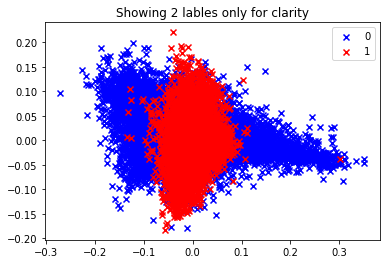

In [135]:
visualize(transformed_X_train, y_train, 7, False, "Showing 2 lables only for clarity")

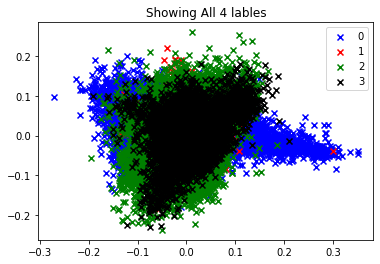

In [136]:
visualize(transformed_X_train, y_train, 7, True, "Showing All 4 lables")

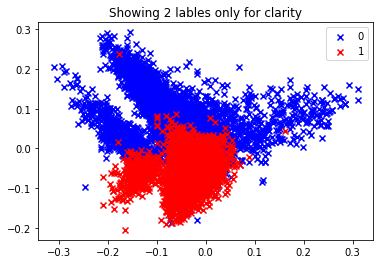

In [137]:
visualize(transformed_X_train, y_train, 2,False, "Showing 2 lables only for clarity")

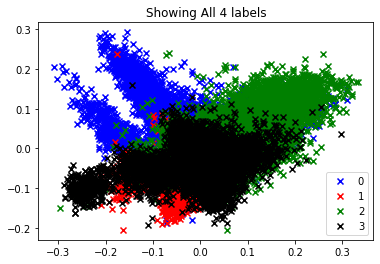

In [138]:
visualize(transformed_X_train, y_train, 2, True, "Showing All 4 labels")

In [139]:
#######
# KNN #
#######

from sklearn.neighbors import KNeighborsClassifier

n_neighbors = np.linspace(3, 50, 10, dtype=int).tolist()
param_grid = {'clf__n_neighbors': n_neighbors, 'clf__weights': ['uniform', 'distance'], 'SVD__n_components': n_features}

model = KNeighborsClassifier()

n_features = np.linspace(2, 500, 10, dtype=int).tolist()

# build a pipeline that will perform tfidfVectorizer and then fit a model
pipeline = Pipeline(
    [
        ("tfidf", TfidfVectorizer()),
        ("SVD", TruncatedSVD()),
        ("clf", model),
    ]
)

sh = RandomizedSearchCV(pipeline, param_grid, cv=5, n_jobs = num_cpu_use).fit(X_train, y_train)




In [142]:
sh.best_estimator_

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('SVD', TruncatedSVD(n_components=168)),
                ('clf',
                 KNeighborsClassifier(n_neighbors=34, weights='distance'))])

In [143]:
sh.cv_results_

{'mean_fit_time': array([141.6590714 , 113.06892023, 269.41044345, 322.3011415 ,
        113.81042566, 223.80724835, 287.26237545, 325.21031427,
        269.35341721, 267.9525321 ]),
 'std_fit_time': array([ 6.39998397,  4.99880757,  4.55580536,  4.84574256,  2.74885359,
         5.06121417, 22.01182688,  6.42743832,  8.81711605, 14.67204705]),
 'mean_score_time': array([247.66054358, 226.7152585 , 271.91537685, 272.79460607,
        222.35882139, 264.21621852, 184.20695624, 153.31942754,
        161.05451889,  99.43405957]),
 'std_score_time': array([ 9.74075564,  4.77374723,  5.97872376,  3.50489562,  4.93464324,
         5.68251705, 42.49214836,  4.92518327,  2.06024739, 16.09674025]),
 'param_clf__weights': masked_array(data=['distance', 'distance', 'uniform', 'uniform',
                    'uniform', 'uniform', 'uniform', 'distance',
                    'distance', 'uniform'],
              mask=[False, False, False, False, False, False, False, False,
                    False, Fa

In [ ]:
#######
# SVM #
#######

#from sklearn.svm import SVC
#clf = SVC(gamma='auto', max_iter = 10000).fit(x_train_tfidf, y_train)

In [ ]:
#accuracy_score(y_test, clf.predict(x_test_tfidf))

In [ ]:
################
# Unsupervised #
################

In [ ]:
##########
# KMEANS #
##########

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=0, max_iter= 10000, n_init=10).fit(x_train_tfidf)

wcss = []
for i in range(1,12):
    print("K: ", i)
    kmeans = KMeans(i)
    kmeans.fit(x_train_tfidf)
    wcss_iter = kmeans.inertia_
    wcss.append(wcss_iter)

number_clusters = range(1,12)
plt.plot(number_clusters, wcss)
plt.title("The Elbow Title")
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')


In [ ]:
from kneed import KneeLocator

kl = KneeLocator(range(1, 12), wcss, curve="convex", direction="decreasing")
print(kl.elbow)

In [ ]:
kmeans = KMeans(4).fit(x_train_tfidf)

import numpy as np
from sklearn.metrics import accuracy_score
from itertools import permutations

pred_train = kmeans.predict(x_train_tfidf)
accuracy = []
map_index = 0
max_accuracy = 0
max_map = []

maps = permutations([0,1,2,3])

for map_list in list(maps):
    curr_label = list(map(lambda x: map_list[x], y_train))
    curr_accuracy = accuracy_score(curr_label, pred_train)
    accuracy.append(curr_accuracy)
    if curr_accuracy > max_accuracy:
        max_accuracy = curr_accuracy
        max_map = map_list

print(max_accuracy)

map_y_test = list(map(lambda x: max_map[x], y_test))
pred_test = kmeans.predict(x_test_tfidf)
accuracy_score(map_y_test, pred_test)



In [ ]:
################
# Gaussian Mix #
################
#from sklearn.mixture import GaussianMixture
#gm = GaussianMixture(n_components=4, random_state=0).fit(x_train_tfidf.toarray())
#

In [ ]:
#accuracy_score(y_test, gm.predict(x_test_tfidf.toarray()))

/home/youngwook/anaconda3/envs/torch_gpu/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/youngwook/anaconda3/envs/torch_gpu/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 71, in _cached_call
    return cache[method]
KeyError: 'predict_proba'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/youngwook/anaconda3/envs/torch_gpu/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/youngwook/anaconda3/envs/torch_gpu/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/home/youngwook/anaconda3/envs/torch_gpu/lib/python3.8/sit

/home/youngwook/anaconda3/envs/torch_gpu/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/youngwook/anaconda3/envs/torch_gpu/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 71, in _cached_call
    return cache[method]
KeyError: 'predict_proba'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/youngwook/anaconda3/envs/torch_gpu/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/youngwook/anaconda3/envs/torch_gpu/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/home/youngwook/anaconda3/envs/torch_gpu/lib/python3.8/sit

/home/youngwook/anaconda3/envs/torch_gpu/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/youngwook/anaconda3/envs/torch_gpu/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 71, in _cached_call
    return cache[method]
KeyError: 'predict_proba'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/youngwook/anaconda3/envs/torch_gpu/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/youngwook/anaconda3/envs/torch_gpu/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/home/youngwook/anaconda3/envs/torch_gpu/lib/python3.8/sit

/home/youngwook/anaconda3/envs/torch_gpu/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/youngwook/anaconda3/envs/torch_gpu/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 71, in _cached_call
    return cache[method]
KeyError: 'predict_proba'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/youngwook/anaconda3/envs/torch_gpu/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/youngwook/anaconda3/envs/torch_gpu/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/home/youngwook/anaconda3/envs/torch_gpu/lib/python3.8/sit

/home/youngwook/anaconda3/envs/torch_gpu/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/youngwook/anaconda3/envs/torch_gpu/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 71, in _cached_call
    return cache[method]
KeyError: 'predict_proba'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/youngwook/anaconda3/envs/torch_gpu/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/youngwook/anaconda3/envs/torch_gpu/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/home/youngwook/anaconda3/envs/torch_gpu/lib/python3.8/sit